In [1]:
import tensorflow as tf
tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.DEBUG)

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.datasets import mnist

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [4]:
model = Sequential()
model.add(layers.Flatten(input_shape=X_train.shape[1:]))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['acc'])

In [6]:
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 6s 128us/sample - loss: 0.2132 - acc: 0.9356 - val_loss: 0.1191 - val_acc: 0.9666
Epoch 2/2
48000/48000 [==============================] - 5s 99us/sample - loss: 0.0945 - acc: 0.9730 - val_loss: 0.1019 - val_acc: 0.9740


<Figure size 432x288 with 0 Axes>

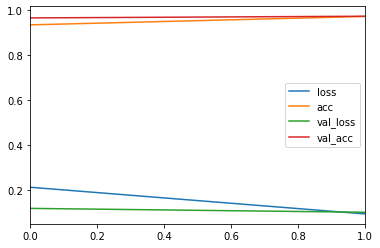

In [7]:
import pandas as pd

df = pd.DataFrame(history.history)
plt.figure()
df.plot()

In [8]:
model.save('model_mnist.hd5')

In [9]:
!ls -lh

total 3.7M
-rw-rw-r-- 1 ubuntu ubuntu  22K Dec 20 22:39 mnist_digits_tf2.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 3.7M Dec 20 22:39 model_mnist.hd5


In [10]:
import tensorflow as tf
tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.DEBUG)

converter = tf.lite.TFLiteConverter.from_keras_model_file('model_mnist.hd5')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

images = tf.cast(X_train, tf.float32)
mnist_ds = tf.data.Dataset.from_tensor_slices((images)).batch(1)
def representative_data_gen():
    for input_value in mnist_ds.take(100):
        yield[input_value]
converter.representative_dataset = representative_data_gen

tflite_quant_model = converter.convert()
with open('model_mnist_quant_uint8.tflite', 'wb') as f:
    f.write(tflite_quant_model)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [26]:
interpreter = tf.lite.Interpreter(model_path='model_mnist_quant_uint8.tflite')
interpreter.allocate_tensors()

img = X_train[2] * 255
img = img.astype('uint8')
# print(interpreter.get_input_details())
interpreter.set_tensor(interpreter.get_input_details()[0]['index'], np.expand_dims(img, axis=0))
interpreter.invoke()
predictions = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [27]:
print(np.argmax(predictions))
print(np.argmax(y_train[2]))

4
4
